# What are LangGraph Subgraphs?

LangGraph **subgraphs** are self-contained workflows that can be embedded within larger parent graphs. They provide a powerful way to:

- **Modularize complex workflows** into smaller, reusable components
- **Isolate state** between different parts of your application
- **Create reusable components** that can be shared across different graphs
- **Simplify debugging** by testing subgraphs independently

Think of subgraphs like functions in programming - they take input, perform a specific task, and return output, but they maintain their own internal state separate from the calling context.

## Setup and Imports

Let's start by importing the necessary libraries:

In [3]:
import os
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from rich import print

## Optional: LangSmith Tracing

LangSmith provides excellent observability for LangGraph workflows. If you want to trace your graph execution and see detailed logs of each step, uncomment the lines below and add your API key:

## Building Our First Subgraph: Greeting Generator

Let's create a subgraph that generates personalized greetings. This subgraph will:

1. **Take a name as input**
2. **Generate a basic greeting** 
3. **Add a friendly inquiry**
4. **Return the complete greeting**

### Key Concepts:

- **Isolated State**: The subgraph has its own `SubgraphState` that is completely separate from any parent graph
- **Self-Contained Logic**: All the greeting logic is encapsulated within the subgraph
- **Reusable**: This subgraph can be used in multiple different parent graphs

Let's define the subgraph state and node functions:

In [4]:
################################ Subgraph Definition ################################


# Define the state for the subgraph.
# This state is isolated from the parent graph's state.
class SubgraphState(TypedDict):
    """
    Define the state schema for the subgraph.
    It tracks the name used for the greeting and the evolving greeting message.
    """

    name: str
    greeting: str


def add_salutation(state: SubgraphState) -> dict:
    """
    Generate an initial greeting for the provided name.
    """
    print('>> Subgraph Node: add_salutation')
    name = state['name']
    # Return the updated greeting to the subgraph state
    return {'greeting': f'Hello, {name}!'}


def add_inquiry(state: SubgraphState) -> dict:
    """
    Append a friendly inquiry to the existing greeting.
    """
    print('>> Subgraph Node: add_inquiry')
    greeting = state['greeting']
    # Update the greeting with an additional phrase
    return {'greeting': f'{greeting} How are you today?'}

## Constructing the Subgraph

Now let's build our subgraph using the `StateGraph` class:

### Graph Construction Steps:
1. **Initialize** the StateGraph with our `SubgraphState` schema
2. **Add nodes** for each step in our greeting process
3. **Define edges** to create the workflow sequence
4. **Compile** the graph into a runnable object

The workflow will be: `START → salutation → inquiry → END`

In [5]:
# Initialize the StateGraph for the subgraph.
subgraph_builder = StateGraph(SubgraphState)

# Define the nodes within the subgraph.
subgraph_builder.add_node('salutation', add_salutation)
subgraph_builder.add_node('inquiry', add_inquiry)

# Define the workflow path within the subgraph.
subgraph_builder.add_edge(START, 'salutation')
subgraph_builder.add_edge('salutation', 'inquiry')
subgraph_builder.add_edge('inquiry', END)

# Compile the subgraph into a runnable object.
subgraph = subgraph_builder.compile()

## Visualizing the Subgraph

Let's see what our subgraph looks like visually. This diagram will show the flow from START through our two nodes to END:

Subgraph structure:

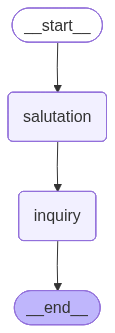

In [6]:
print('Subgraph structure:')
# Visualize the compiled subgraph structure.
try:
    from IPython.display import Image, display

    display(Image(subgraph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Creating the Parent Graph

Now let's create a **parent graph** that will use our subgraph as one of its components. This demonstrates the key benefit of subgraphs: **composition**.

### Parent Graph Responsibilities:
- **Prepare input** for the subgraph
- **Invoke the subgraph** and handle its output
- **Add additional processing** (like a closing message)
- **Manage the overall workflow**

### State Mapping:
Notice how the parent graph has its own state (`ParentState`) that's different from the subgraph state. We'll need to map data between them when invoking the subgraph.

In [7]:
################################ Parent Graph Definition ################################


# Define the state for the parent graph.
# This state manages the overall message flow and includes the name input.
class ParentState(TypedDict):
    """
    Define the state schema for the parent graph.
    It holds the initial name and the final composite message.
    """

    name: str
    full_message: str

## Parent Graph Node Functions

Here are the key functions for our parent graph:

### `prepare_input()` 
Sets up the initial message to prepare for subgraph execution.

### `run_subgraph()` - **The Key Function**
This is where the magic happens! This function:
1. **Maps parent state to subgraph input** - Takes `name` from parent state
2. **Invokes the compiled subgraph** - Runs the entire greeting workflow
3. **Extracts the result** - Gets the `greeting` from subgraph output
4. **Maps back to parent state** - Updates the parent's `full_message`

### `add_closing()`
Adds a final touch to the message after the subgraph completes.

### Important: State Isolation
Notice how the parent and subgraph maintain completely separate states, and we explicitly handle the data mapping between them.

In [8]:
def prepare_input(state: ParentState) -> dict:
    """
    Initialize the full message with a preparatory statement.
    """
    print('-> Parent Node: prepare_input')
    # Set an initial message based on the input name
    return {'full_message': f'Preparing message for {state["name"]}...'}


def run_subgraph(state: ParentState) -> dict:
    """
    Execute the predefined subgraph and incorporate its output into the parent state.
    """
    print('-> Parent Node: run_subgraph (invoking subgraph now)')

    # Map parent state variables to the subgraph's expected input state.
    subgraph_input = {'name': state['name']}

    # Invoke the compiled subgraph with its specific input.
    subgraph_output = subgraph.invoke(subgraph_input)

    # Extract the final greeting from the subgraph's output state.
    final_greeting = subgraph_output['greeting']

    print('-> Parent Node: run_subgraph (subgraph finished)')

    # Update the parent's full_message with the subgraph's result.
    return {'full_message': final_greeting}


def add_closing(state: ParentState) -> dict:
    """
    Append a concluding remark to the generated message.
    """
    print('-> Parent Node: add_closing')
    message = state['full_message']
    # Concatenate the closing phrase to the existing message
    return {'full_message': f'{message} Have a great day!'}

## Building the Parent Graph

Now let's construct our parent graph that will orchestrate the entire workflow:

### Graph Structure:
`START → prepare → generate_greeting → close → END`

The `generate_greeting` node is where our **subgraph gets invoked**. This demonstrates how subgraphs act like sophisticated function calls within a larger workflow.

In [9]:
# Initialize the StateGraph for the parent graph.
parent_builder = StateGraph(ParentState)

# Define the nodes within the parent graph.
parent_builder.add_node('prepare', prepare_input)
parent_builder.add_node('generate_greeting', run_subgraph)
parent_builder.add_node('close', add_closing)

# Define the main workflow path for the parent graph.
parent_builder.add_edge(START, 'prepare')
parent_builder.add_edge('prepare', 'generate_greeting')
parent_builder.add_edge('generate_greeting', 'close')
parent_builder.add_edge('close', END)

# Compile the parent graph into a runnable object.
main_graph = parent_builder.compile()

## Visualizing the Complete System

Let's see how our parent graph looks. Notice that from the parent graph's perspective, the subgraph appears as a single node, even though it contains its own internal workflow.

Parent graph structure:

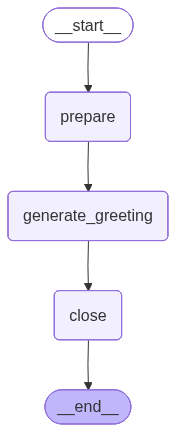

In [10]:
print('Parent graph structure:')
# Visualize the compiled parent graph structure.
try:
    from IPython.display import Image, display

    display(Image(main_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
################################ Graph Execution ################################

# Define the initial input for the main graph.
initial_input = {'name': 'Alice'}
print(f'🚀 Starting graph with input: {initial_input}\n')

# Stream events to observe intermediate node outputs.
# Iterate through each event to print node outputs as they occur.
for event in main_graph.stream(initial_input, debug=True):
    for node, output in event.items():
        print(f"✅ Output from '{node}':")
        print(f'   {output}')
        print('--------------------')

# Invoke the graph to get the final state directly.
final_state = main_graph.invoke(initial_input)
print(f'\n✨ Final Result:\n{final_state["full_message"]}')

🚀 Starting graph with input: {'name': 'Alice'}

[values] {'name': 'Alice'}


-> Parent Node: prepare_input

[updates] {'prepare': {'full_message': 'Preparing message for Alice...'}}


✅ Output from 'prepare':

{'full_message': 'Preparing message for Alice...'}

--------------------

[values] {'name': 'Alice', 'full_message': 'Preparing message for Alice...'}


-> Parent Node: run_subgraph (invoking subgraph now)

>> Subgraph Node: add_salutation

>> Subgraph Node: add_inquiry

-> Parent Node: run_subgraph (subgraph finished)

[updates] {'generate_greeting': {'full_message': 'Hello, Alice! How are you today?'}}


✅ Output from 'generate_greeting':

{'full_message': 'Hello, Alice! How are you today?'}

--------------------

[values] {'name': 'Alice', 'full_message': 'Hello, Alice! How are you today?'}


-> Parent Node: add_closing

[updates] {'close': {'full_message': 'Hello, Alice! How are you today? Have a great day!'}}


✅ Output from 'close':

{'full_message': 'Hello, Alice! How are you today? Have a great day!'}

--------------------

[values] {'name': 'Alice', 'full_message': 'Hello, Alice! How are you today? Have a great day!'}


-> Parent Node: prepare_input

-> Parent Node: run_subgraph (invoking subgraph now)

>> Subgraph Node: add_salutation

>> Subgraph Node: add_inquiry

-> Parent Node: run_subgraph (subgraph finished)

-> Parent Node: add_closing

✨ Final Result:
Hello, Alice! How are you today? Have a great day!